In [1]:
import numpy as np
from numpy.random import randint
from IPython.display import clear_output
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
from keras import backend as K

Using TensorFlow backend.


In [3]:
import pyglet
from pyglet import app
from pyglet.window import Window, mouse, key
from pyglet import gl

pyglet.options['audio'] = ('openal', 'pulse', 'directsound', 'silent')
from pyglet.media import procedural
sine_hi = procedural.WhiteNoise(.05)
sine_lo = procedural.Sine(.2, frequency=300)

In [4]:
NOISE_MAG = .1

In [19]:
# env

class Env(object):
    def __init__(self, r, c, vis_r):
        self.vis_r = vis_r #radius of snake vision
        self.r = r
        self.c = c
        self.channels = 4 # channels: head, body, food, walls
        self.state = np.zeros((r, c, self.channels))
        self.state_padded = np.zeros((r+vis_r*2, c+vis_r*2, self.channels))
        self.define_model()
        self.reset()
        
    def reset(self, random_length=True):
        self.p = [randint(1, self.r-2), randint(1, self.c-2)]
        self.place_food()
        
        self.tail = []
        if random_length:
            self.length = np.random.randint(4, self.r*self.c)
        else:
            self.length = 4
        self.step_count = 0
        self.end = False
        
        self.draw()
        
    def define_model(self):
        img_rows, img_cols = self.vis_r*2, self.vis_r*2
        
        input_shape = None
        if K.image_data_format() == 'channels_first':
            input_shape = (self.channels, img_rows, img_cols)
        else:
            input_shape = (img_rows, img_cols, self.channels)
        
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape))
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        #self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.20))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.20))
        self.model.add(Dense(4, activation='softmax'))
        
        self.model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr=1.0),
              metrics=['accuracy'])
        
    def is_fail(self, p):
        # out of bounds
        if p[0] < 0 or p[0] > self.r-1 or p[1] < 0 or p[1] > self.c-1:
            return True
        
        hit_body = self.state[p[0], p[1], 1] == 1 # body
        hit_wall = self.state[p[0], p[1], 3] == 1 # wall
        
        return hit_body or hit_wall
    
    def is_food(self, p):
        return self.state[p[0], p[1], 2] == 1
    
    def draw(self):
        self.state[:] = 0
        
        # draw head
        self.state[self.p[0], self.p[1], 0] = 1
        
        # draw body
        for b in self.tail:
            self.state[b[0], b[1], 1] = 1
        
        # draw food
        self.state[self.f[0], self.f[1], 2] = 1
        
        #draw walls
        self.state[:,0,3] = 1
        self.state[:,self.c-1,3] = 1
        
        self.state[0,:,3] = 1
        self.state[self.r-1,:,3] = 1
        
    def snake_vision(self):
        self.state_padded[:] = 0
        self.state_padded[self.vis_r:self.vis_r+self.r,
                          self.vis_r:self.vis_r+self.c] = self.state

        p = self.vis_r #padding
        r, c = self.p[0]+p, self.p[1]+p # offset
        
        _state = self.state_padded[r-p:r+p, c-p:c+p].reshape(1, p*2, p*2, self.channels)
        
        # food radar
        if self.p[0] < self.f[0]:
            _state[0,0,0,2] = 1
        else:
            _state[0,1,0,2] = 1
        if self.p[1] < self.f[1]:
            _state[0,0,0,2] = 1
        else:
            _state[0,0,1,2] = 1
                
        return _state
    
    def move_p(self, p, action):
        newp = [p[0], p[1]]
        if action == 0: #up
            newp[0] -= 1
        if action == 1: #down
            newp[0] += 1
        if action == 2: #left
            newp[1] -= 1
        if action == 3: #right
            newp[1] += 1
        return newp
    
    def random_action(self):
        p = self.p
        possible = []
        if self.state[p[0]-1, p[1], 1] == 0: # up
            possible += [0]
        if self.state[p[0]+1, p[1], 1] == 0: # down
            possible += [1]
        if self.state[p[0], p[1]-1, 1] == 0: # left
            possible += [2]
        if self.state[p[0], p[1]+1, 1] == 0: # right
            possible += [3]

        if len(possible) > 0:
            return np.random.choice(possible)
        else:
            return np.random.choice([0,1,2,3])
        
    def place_food(self):
        self.f = [randint(1, self.r-2), randint(1, self.c-2)]
        while self.state[self.f[0], self.f[1], 1] == 1 or self.state[self.f[0], self.f[1] , 0] == 1 or self.state[self.f[0], self.f[1], 3] == 1:
            self.f = [randint(1, self.r-2), randint(1, self.c-2)]
    
    def step(self, explore=1.0, max_steps=150, noise=False):
        self.step_count += 1
        if self.step_count > max_steps: # max steps
            self.end = True
            return (None, None, 0)
        
        _state = None
        _action = None
        _reward = 1 # if you survive
        
        # get the state
        _state = self.snake_vision()
        
        if noise:
            s = _state.shape
            _state += NOISE_MAG * np.random.randn(s[0], s[1], s[2], s[3])

        if np.random.random() < explore:
            _action = self.random_action()
        else:
            # sample action
            dist = self.model.predict(_state)
            _action = np.argmax(dist)

        newp = self.move_p(self.p, _action)
            
        if self.is_food(newp):
            _reward = 2
            #grow and move food
            self.length += 1
            self.place_food()

        elif self.is_fail(newp):
            self.end = True
            return (None, None, 0)
                
        # move to new position
        self.p = newp
            
        self.draw()
        
        # manage tail
        self.tail.insert(0, np.copy(self.p))
        if len(self.tail) > self.length:
            self.tail.pop()
        
        return (_state.copy(), _action, _reward) #sar

In [119]:
# create environment

env = Env(r=20, c=20, vis_r=11)

In [114]:
x_train, y_train = [], []

In [126]:
# gather some training data, then train it

i = 0
while len(x_train) < 50000:
    i += 1
    if (i+1) % 2000 == 0:
        print(len(x_train))
        
    session = []
    
    foods = 0
    while not env.end:
        sar = env.step(explore=1, noise=False)
        
        if foods == 0:
            session.append(sar)
        
        if sar[2] == 2: # 1 survived, 2 food
            foods += 1
            
        if foods == 2:
            for s in session:
                x_train.append(s[0])
                action = np.zeros((1, 4))
                action[0, s[1]] = 1
                y_train.append(action)
            env.end = True
            continue
            
    env.reset(random_length=True)

20160
20351
20562
20684
20849
21075
21242
21457
21578
21679
21782
21874
21938
22039
22139
22326
22423
22617
22675
22782
22956
23200
23332
23434
23512
23674
23817
23966
24059
24134
24233
24378
24395
24473
24657
24863
24897
25048
25093
25139
25312
25466
25629
25671
25831
25959
26078
26273
26425
26545
26723
26805
27033
27071
27223
27361
27499
27595
27714
27824
27959
28048
28162
28261
28341
28400
28553
28660
28848
29150
29381
29519
29548
29785
29960
30174
30328
30432
30492
30672
30796
30899
31176
31200
31408
31574
31747
31791
31870
32052
32269
32505
32688
32749
32846
33089
33280
33547
33638
33723
33768
33868
34025
34204
34375
34421
34546
34675
34755
34877
35051
35123
35288
35380
35500
35593
35778
35915
36002
36095
36322
36408
36566
36639
36668
36933
37024
37161
37361
37394
37491
37580
37643
37767
38002
38090
38243
38315
38375
38447
38574
38680
38871
39039
39177
39268
39395
39487
39619
39741
39934
40008
40075
40166
40340
40398
40536
40739
40844
40891
41171
41299
41445
41721
41818
41908
4195

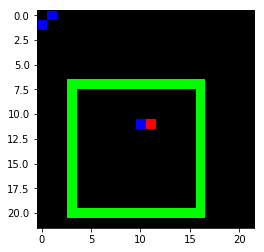

In [140]:
for i in range(100):
    img = x_train[i].reshape(env.vis_r*2, env.vis_r*2, env.channels)
    img[:,:,1] += img[:,:,3]
    img = img[:,:,:3]
    clear_output(wait=True)
    fig = plt.imshow(img, interpolation='none')
    plt.show()

In [133]:
_x_train = np.vstack(x_train)
_y_train = np.vstack(y_train)

s = _x_train.shape
#_x_train += NOISE_MAG * np.random.randn(s[0], s[1], s[2], s[3])

env.model.fit(_x_train, _y_train, epochs=1, verbose=1)

Epoch 1/1
50000/50000 [==============================] - 92s - loss: 0.8969 - acc: 0.5679    


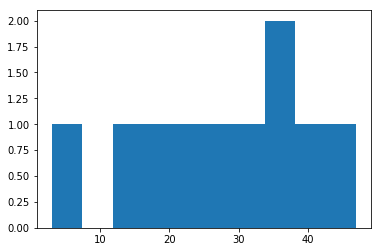

In [134]:
# run after training

rewards = []

env.reset(random_length=False)
for i in range(10):
    total_r = 0
    while not env.end:
        sar = env.step(explore=0, max_steps=800)
            
        if sar[2] == 2: # 1 survived, 2 food
            total_r += 1
    rewards.append(total_r)
    env.reset(random_length=False)
    
fig = plt.hist(rewards)

In [141]:
# visualize pyglet

bw, bh = 10, 10
win_width, win_height = bw*env.c, bh*env.r

# create window and run display it
win = Window(width=win_width, height=win_height)

def on_mouse_press(x, y, button, modifiers):
    env.reset(random_length=False)
    
win.push_handlers(on_mouse_press)

def draw_rect(x, y, w, h, color):
    pyglet.graphics.draw(6, gl.GL_TRIANGLES,
                    ('v2f', [x, y, 
                             x+w, y,
                             x+w, y+h, 
                             x, y, 
                             x, y+h, 
                             x+w, y+h]),
                    ('c4f', color * 6))
    

env.reset(random_length=False)

if 'loop' in globals():
    pyglet.clock.unschedule(loop)
    
def loop(e):
    global env
    if not env.end:
        sar = env.step(explore=0, noise=False, max_steps=10000000)
        if sar[2] == 2:
            # play a sound
            sine_hi.seek(0)
            sine_hi.play()
        if env.end:
            sine_lo.seek(0)
            sine_lo.play()
            #env.reset(random_length=False)

def on_draw():
    global env
    
    win.clear()
    for index, x in np.ndenumerate(env.state):
        if x != 0:
            # draw a rect
            c = [1,1,1,1]
            if index[2] == 1:
                c = [.5,.5,.5,1]
            elif index[2] == 2:
                c = [0,1,0,1]
            elif index[2] == 3:
                c = [1,1,0,1]

            draw_rect(index[0]*bw, index[1]*bh, bw, bh, c)
win.on_draw = on_draw

pyglet.clock.schedule(loop)
    
pyglet.app.run()
    
win.close()

In [270]:
# visualize agent

for i in range(5):
    while not env.end:
        env.step(explore=0)
        clear_output(wait=True)
        plt.imshow(env.state, cmap=plt.cm.rainbow, vmin=-1, vmax=1)
        plt.show()
    env.reset()

KeyboardInterrupt: 